# Convolutional Autoencoder (CAE)
### Authors: Sergi Nogués and Gilles Salem

This is the second assignment for ACML at the MSc in
Artificial Intelligence at Maastricht University.

[Source code](https://github.com/serginogues/convolutional_autoencoder)

In [34]:
import torch
from torchvision import datasets
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from torch.optim import lr_scheduler
from torchvision import transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Compatibility with CUDA and GPU -> remember to move into GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device: ", device)

SAVE_PATH = 'models/cae.pth'
SAVE_PATH2 = 'models/cae2.pth'
SAVE_PATH3 = 'models/cae3.pth'
SAVE_PATH4 = 'models/cae4.pth'

device:  cuda


## Data

CIFAR-10 dataset: https://www.cs.toronto.edu/~kriz/cifar.html

### Train and Test Datasets

_Divide your dataset into training (80%), validation (10%) and test (10%). Normalize the data:_

In [35]:
DATA_PATH = 'D:/UM/ACML/Assignments/'
VALIDATION_SIZE = 0.1  # percentage of the training set used for validation
TRAIN_SIZE = 0.8
TEST_SIZE = 0.1
BATCH_SIZE = 64

The CIFAR10 train and test datasets can be downloaded as follows.
Note that the _ToTensor()_ transform is applied to convert from PIL images
to Tensors and rescale from range $[0, 255]$ to range $[0, 1]$.

In [34]:
train_dataset = datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transforms.ToTensor())
classes = train_dataset.classes

Files already downloaded and verified
Files already downloaded and verified


Now we can plot any image to check the previous code worked:

image label: truck
torch.Size([3, 32, 32])
(32, 32, 3)


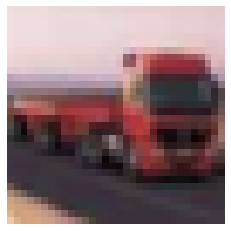

In [37]:
img, label = train_dataset[6150]
print("image label:", classes[label])

# since we already used the transform, type(img) = torch.Tensor
print(img.shape)

# plot with original axis before converting PIL Image to Tensor, otherwise an Exception arises
# C × H × W to H × W × C
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.show()

### 80% train, 10% test and 10% validation

In order to divide our dataset in test, train and validation, we need first to
concatenate both train and test and then split with the desired proportion.


# samples train set = 48000
# samples test set = 6000
# samples validation set = 6000
Sample distribution: 80% train, 10% test, 10% validation


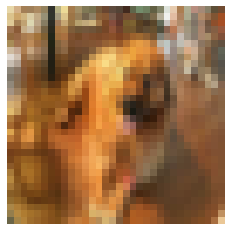

In [5]:
concat_dataset = ConcatDataset([train_dataset, test_dataset])
len_ = len(concat_dataset)
train_set, test_set, valid_set = random_split(concat_dataset, [round(len_ * TRAIN_SIZE), round(len_ * TEST_SIZE), round(len_ * VALIDATION_SIZE)])

print("")
print("# samples train set =", len(train_set))
print("# samples test set =", len(test_set))
print("# samples validation set =", len(valid_set))
total_samp = len(train_set) + len(test_set) + len(valid_set)
print("Sample distribution: " + str(round((len(train_set) / total_samp) * 100))
      + "% train, " + str(round((len(test_set) / total_samp) * 100)) + "% test, "
      + str(round((len(valid_set) / total_samp) * 100)) + "% validation")

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=0, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

Xs, Ys = iter(train_loader).next()
images = Xs.numpy()
plt.imshow(np.transpose(images[30], (1, 2, 0)))
plt.axis('off')
plt.show()

## Reconstruction

_Implement the autoencoder network specified above. Run the training for at least 10 epochs, and plot the
evolution of the error with epochs._

### Architecture

We first define our simple convolutional autoencoder (CAE) class.

In [6]:
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()

        padding = 1
        stride = 1
        kernel = 3
        channels = [8, 12, 16, 12]

        # Encoder
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=channels[0], kernel_size=kernel, padding=padding, stride=stride)
        self.conv2 = nn.Conv2d(in_channels=channels[0], out_channels=channels[1], kernel_size=kernel, padding=padding, stride=stride)
        self.conv3 = nn.Conv2d(in_channels=channels[1], out_channels=channels[2], kernel_size=kernel, padding=padding, stride=stride)
        self.maxpool = nn.MaxPool2d(kernel_size=kernel-1, stride=stride, padding=0)

        # Decoder
        self.t_conv1 = nn.ConvTranspose2d(in_channels=channels[2], out_channels=channels[3], kernel_size=kernel+1, padding=padding, stride=stride)
        self.t_conv2 = nn.ConvTranspose2d(in_channels=channels[3], out_channels=3, kernel_size=kernel+1, padding=padding, stride=stride)
        self.print_latent_shape = 0

    def forward(self, x):
        # encoder
        x = F.relu(self.conv1(x))

        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))

        if self.print_latent_shape == 0:
            print("Latent space shape: " + str(x.shape))
            self.print_latent_shape +=1

        # decoder
        x = F.relu(self.t_conv1(x))
        y = F.sigmoid(self.t_conv2(x))
        return y

### Hyperparams and training

Then define the training hyperparameters and train the model for 10 epochs and batch size 64.

Latent space shape: torch.Size([64, 16, 30, 30])


C:\Users\nogue\.virtualenvs\sergi_env\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0, Loss = 0.56751041388518
Epoch 1, Loss = 0.556609879839786
Epoch 2, Loss = 0.5549444592790386
Epoch 3, Loss = 0.554303871829105
Epoch 4, Loss = 0.5528692923898535
Epoch 5, Loss = 0.5520628838451269
Epoch 6, Loss = 0.5517129506008007
Epoch 7, Loss = 0.5514180240320429
Epoch 8, Loss = 0.5513763684913217
Epoch 9, Loss = 0.5511177570093463
Training finished


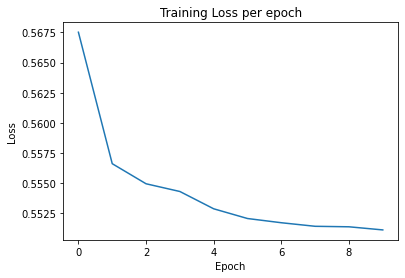

In [8]:
EPOCHS = 10
LR = 0.01

model = CAE().to(device)
criterion = nn.BCELoss()  # loss function
#optimizer = optim.SGD(model.parameters(), lr=LR)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

def train(model, save=SAVE_PATH):
    loss_history = []
    running_loss = 0.0
    for i in range(EPOCHS):
        # TRAIN MODEL
        loss_sum = 0
        n = 0
        for j, data in enumerate(train_loader, 0):
            n = j
            # get the training data
            images, label = data
            images = images.to(device)

            # Before the backward pass, set gradients to zero
            optimizer.zero_grad()

            # predict
            output = model.forward(images)

            # compute loss
            loss = criterion(output, images)
            loss_sum += round(float(loss.item()), 4)

            # backpropagate loss error
            loss.backward()

            # optimize with backprop
            optimizer.step()
            del data, images, label

        # region print current loss
        loss_epoch = loss_sum/n
        loss_history.append(loss_epoch)
        print("Epoch "+ str(i) +", Loss = "+ str(loss_epoch))

        # SAVE THE MODEL every EPOCH
        torch.save(model.state_dict(), save)

    print("Training finished")

    # PLOT ACCURACY
    plt.plot(loss_history)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Training Loss per epoch')
    plt.show()

train(model)

### Test trained model

_Report also the test error._

In [9]:
def test(trained_model):
    with torch.no_grad():
        loss_sum = 0
        n = 0
        for images, labels in test_loader:
            output = trained_model.forward(images)
            loss = criterion(output, images)
            loss_sum += round(float(loss.item()), 4)
            n += 1
        loss_final = loss_sum/n
        print("Test Loss = ", loss_final)

cae1 = CAE()
cae1.load_state_dict(torch.load(SAVE_PATH))
cae1.eval()
test(cae1)

Latent space shape: torch.Size([64, 16, 30, 30])
Test Loss =  0.5507148936170213


We now see our trained model's performance with these 5 images:

<ipython-input-10-9863a18850b2>:8: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


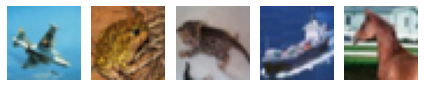

In [10]:
images, labels = iter(test_loader).next()
images_plot = images.numpy()

ff, axarr = plt.subplots(1, 5, constrained_layout=True)
for i in range(5):
    axarr[i].imshow(np.transpose(images_plot[i], (1, 2, 0)))
    axarr[i].axis('off')
plt.tight_layout()
plt.show()

After 10 epochs of training the reconstruction is good:

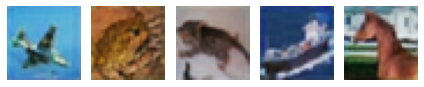

In [11]:
# Sample outputs
output = cae1.forward(images)
output = output.detach().numpy()

ff2, axarr = plt.subplots(1, 5)
for i in range(5):
    axarr[i].imshow(np.transpose(output[i], (1, 2, 0)))
    axarr[i].axis('off')
plt.tight_layout()
plt.show()

### Latent space size

_What is the size of the latent space representation of the above network?_

$W' = \frac{W - K + 2P}{S} + 1$

Encoder:
1. out_conv1 = batch_size x 8 x 32 x 32 where $32 = 32 - 3 + 2 + 1$
- out_pool1 = batch_size x 8 x 31 x 31
- out_conv2 = batch_size x 12 x 31 x 31
- out_pool2 = batch_size x 12 x 30 x 30
- out_conv3 = batch_size x 16 x 30 x 30

Latent space size = 16 x 30 x 30 = 14400

### Playing with latent space shape

_Try other architectures (e.g. fewer intermediate layers, different number of channels, filter sizes or stride and
padding configurations) to answer questions such as: What is the impact of those in the reconstruction error
after training? Is there an obvious correlation between the size of the latent space representation and the error?_

#### Small Latent Space

We first try defining a model such that the latent space is smaller.

In [12]:
class CAE2(nn.Module):
    def __init__(self):
        super(CAE2, self).__init__()

        channels=[5, 8, 10, 8, 5]
        padding = 1
        stride = 1
        kernel = 3

        # Encoder
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=channels[0], kernel_size=(4, 4), padding=padding, stride=(2,2))
        self.conv2 = nn.Conv2d(in_channels=channels[0], out_channels=channels[1], kernel_size=(4, 4), padding=padding, stride=stride)
        self.conv3 = nn.Conv2d(in_channels=channels[1], out_channels=channels[2], kernel_size=(4, 4), padding=padding, stride=stride)
        self.maxpool = nn.MaxPool2d(kernel_size=kernel-1, stride=stride, padding=0)

        # Decoder
        self.t_conv1 = nn.ConvTranspose2d(in_channels=channels[2], out_channels=channels[3], kernel_size=(6, 6), padding=padding, stride=(2, 2))
        self.t_conv2 = nn.ConvTranspose2d(in_channels=channels[3], out_channels=channels[4], kernel_size=(6, 6), padding=padding, stride=stride)
        self.t_conv3 = nn.ConvTranspose2d(in_channels=channels[4], out_channels=3, kernel_size=(6, 6), padding=padding, stride=stride)
        self.print_latent_shape = 0

    def forward(self, x):
        # encoder
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        if self.print_latent_shape == 0:
            print("Latent space shape: " + str(x.shape))
            self.print_latent_shape +=1

        # decoder
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        y = F.sigmoid(self.t_conv3(x))
        return y


Latent space shape: torch.Size([64, 10, 12, 12])
Epoch 0, Loss = 0.6068088117489986
Epoch 1, Loss = 0.5855994659546069
Epoch 2, Loss = 0.5823046728971963
Epoch 3, Loss = 0.5805706275033378
Epoch 4, Loss = 0.5793363150867826
Epoch 5, Loss = 0.578520827770361
Epoch 6, Loss = 0.5780468624833109
Epoch 7, Loss = 0.5776795727636853
Epoch 8, Loss = 0.577644993324432
Epoch 9, Loss = 0.5772190921228303
Training finished


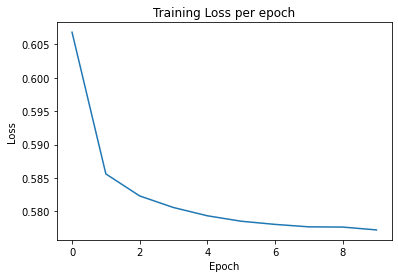

In [13]:
EPOCHS = 10
model = CAE2().to(device)
criterion = nn.BCELoss()  # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
train(model, save=SAVE_PATH2)

The latent space is now smaller than before: 10 x 12 x 12; and the training error higher.

Latent space shape: torch.Size([64, 10, 12, 12])
Test Loss =  0.5744691489361705


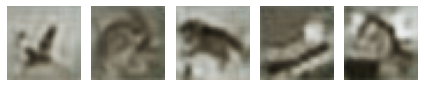

In [14]:
model = CAE2()
model.load_state_dict(torch.load(SAVE_PATH2))
model.eval()
test(model)

# Sample outputs
output = model.forward(images)
output = output.detach().numpy()

ff2, axarr = plt.subplots(1, 5)
for i in range(5):
    axarr[i].imshow(np.transpose(output[i], (1, 2, 0)))
    axarr[i].axis('off')
plt.tight_layout()
plt.show()

As expected the reconstruction test error is higher and the reconstructed images are worse.

#### Bigger latent space

Now let's try with a more channels and more layers to improve the results.

In [15]:
class CAE3(nn.Module):
    def __init__(self):
        super(CAE3, self).__init__()

        channels=[16, 32, 64, 32, 16]
        padding = 1
        stride = 1
        kernel = 3

        # Encoder
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=channels[0], kernel_size=(3, 3), padding=padding, stride=stride)
        self.conv2 = nn.Conv2d(in_channels=channels[0], out_channels=channels[1], kernel_size=(3, 3), padding=padding, stride=stride)
        self.conv3 = nn.Conv2d(in_channels=channels[1], out_channels=channels[2], kernel_size=(3, 3), padding=padding, stride=stride)
        self.maxpool = nn.MaxPool2d(kernel_size=kernel-1, stride=stride, padding=0)

        # Decoder
        self.t_conv1 = nn.ConvTranspose2d(in_channels=channels[2], out_channels=channels[3], kernel_size=(3, 3), padding=padding, stride=stride)
        self.t_conv2 = nn.ConvTranspose2d(in_channels=channels[3], out_channels=channels[4], kernel_size=(4, 4), padding=padding, stride=stride)
        self.t_conv3 = nn.ConvTranspose2d(in_channels=channels[4], out_channels=3, kernel_size=(4, 4), padding=padding, stride=stride)
        self.print_latent_shape = 0

    def forward(self, x):
        # encoder
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        if self.print_latent_shape == 0:
            print("Latent space shape: " + str(x.shape))
            self.print_latent_shape +=1

        # decoder
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        y = F.sigmoid(self.t_conv3(x))
        return y


Latent space shape: torch.Size([64, 64, 30, 30])
Epoch 0, Loss = 0.576827903871829
Epoch 1, Loss = 0.5584791722296396
Epoch 2, Loss = 0.5550524699599465
Epoch 3, Loss = 0.5541716955941249
Epoch 4, Loss = 0.5538397863818418
Epoch 5, Loss = 0.5534586114819765
Epoch 6, Loss = 0.5532344459279038
Epoch 7, Loss = 0.5530841121495327
Epoch 8, Loss = 0.5529846461949259
Epoch 9, Loss = 0.5528233644859809
Training finished


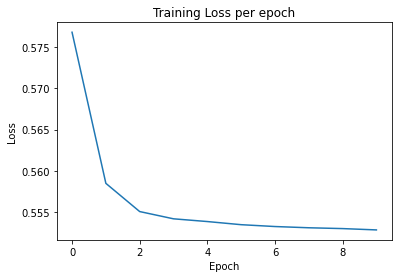

In [16]:
model = CAE3().to(device)
criterion = nn.BCELoss()  # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train(model, save=SAVE_PATH3)

The latent space is now bigger than before 64 x 30 x 30 and the training error lower.

Latent space shape: torch.Size([64, 64, 30, 30])
Test Loss =  0.550427659574468


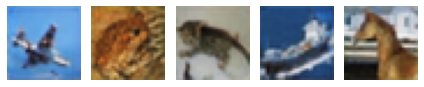

In [17]:
cae3 = CAE3()
cae3.load_state_dict(torch.load(SAVE_PATH3))
cae3.eval()
test(cae3)

# Sample outputs
output = cae3.forward(images)
output = output.detach().numpy()

ff2, axarr = plt.subplots(1, 5)
for i in range(5):
    axarr[i].imshow(np.transpose(output[i], (1, 2, 0)))
    axarr[i].axis('off')
plt.tight_layout()
plt.show()

As expected the reconstruction test error is lower and the reconstructed images are better. Although there is not much difference with
the original architecture, we can see an improvement at reconstructing the colors.

## Colorization

_Adapt your network from the previous part such that it learns to reconstruct colors by feeding in grayscale
images but predicting all RGB channels. As a starting point, use the hyperparameters (including the network
architecture) that you identified to yield the best performance in Exercise 3.2._


_Report on your results and reason about potential shortcomings of your network.
What aspects of the architecture/hyperparameters/optimization could be improved upon to fit the model more adequately to this
application? Try out some ideas._

### Custom Dataset YUV

An easier way to predict RGB colors is to predict chrominance from grayscale inputs, because the model
has only two output channels instead of three.

In [255]:
import cv2

train_dataset = datasets.CIFAR10(root=DATA_PATH, train=True, download=True)
yuv_data = np.array([cv2.cvtColor(np.array(data[0]), cv2.COLOR_BGR2YUV) for data in train_dataset])
x_train = np.array([yuv_data[i:i+BATCH_SIZE][:, :, :, 0, np.newaxis]/255 for i in range(0, len(train_dataset), BATCH_SIZE)])
x_train = [torch.from_numpy(data).reshape((BATCH_SIZE,1,32,-1)) for data in x_train]
y_train = np.array([yuv_data[i:i+BATCH_SIZE][:, :, :, 1:]/255 for i in range(0, len(train_dataset), BATCH_SIZE)])
y_train = [torch.from_numpy(data).reshape((BATCH_SIZE,2,32,-1)) for data in y_train]

test_dataset = datasets.CIFAR10(root=DATA_PATH, train=False, download=True)
yuv_data2 = np.array([cv2.cvtColor(np.array(data[0]), cv2.COLOR_BGR2YUV) for data in test_dataset])
x_test = np.array([yuv_data2[i:i+BATCH_SIZE][:, :, :, 0, np.newaxis]/255 for i in range(0, len(test_dataset), BATCH_SIZE)])
x_test = [torch.from_numpy(data).reshape((BATCH_SIZE,1,32,-1)) for data in x_test]
y_test = np.array([yuv_data2[i:i+BATCH_SIZE][:, :, :, 1:]/255 for i in range(0, len(test_dataset), BATCH_SIZE)])
y_test = [torch.from_numpy(data).reshape((BATCH_SIZE,2,32,-1)) for data in y_test]

Files already downloaded and verified
Files already downloaded and verified


Let's see what YUV channels look like, how to access Chrominance
and how to reconstruct back the RGB color by combining the grayscale image with the two Chrominance channels.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


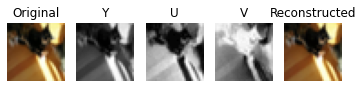

In [256]:
idx1 = np.random.randint(0, 50)
def plot_colorization(lumi, chrom, idx):
    #lumi = x_train[idx1][0].numpy().reshape(32, 32, 1)
    lumi = lumi.numpy().reshape(32, 32, 1)
    chrom = chrom.numpy().reshape(32, 32, 2)

    yuv_reconstructed = cv2.merge((lumi, chrom[:,:,0], chrom[:,:,1]))
    img_float32 = np.float32(yuv_reconstructed)
    rgb_image = cv2.cvtColor(img_float32, cv2.COLOR_YUV2BGR)

    plt.subplot(1,5,1)
    plt.imshow(test_dataset[idx* BATCH_SIZE][0])
    plt.title('Original')
    plt.axis('off')
    plt.subplot(1,5,2)
    plt.imshow(lumi, cmap="gray")
    plt.title('Y')
    plt.axis('off')
    plt.subplot(1,5,3)
    plt.imshow(chrom[:,:,0],cmap="gray")
    plt.title('U')
    plt.axis('off')
    plt.subplot(1,5,4)
    plt.imshow(chrom[:,:,1],cmap="gray")
    plt.title('V')
    plt.axis('off')
    plt.subplot(1,5,5)
    plt.imshow(rgb_image)
    plt.title('Reconstructed')
    plt.axis('off')
    plt.show()

plot_colorization(x_test[idx1][0], y_test[idx1][0], idx1)

### Architecture

The proposed architecture decodes the latent space with two linear layers. The latent space size
will be 32 x 8 x 8. Input and hidden nodes are activated by ReLU and output layer by Sigmoid.

In [264]:
class CAE4(nn.Module):

    def __init__(self):
        super(CAE4, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), padding=(1, 1))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=(1, 1))
        self.linear1 = nn.Linear(in_features=32*8*8, out_features=512)
        self.linear2 = nn.Linear(in_features=512, out_features=2048)
        self.print_latent_shape = 0

    def forward(self, x):
        # Encoder Phase
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))

        if self.print_latent_shape == 0:
            print("Latent space shape: " + str(x.shape))
            self.print_latent_shape +=1

        x = x.view(BATCH_SIZE,-1)
        # Decoder Phase
        x = F.relu(self.linear1(x))
        y = torch.sigmoid(self.linear2(x)).view(64, 2, 32, 32)
        return y

### Hyperparameters and Training

In addition to the new architecture, early stop is used to prevent overfitting.
Thus, the training will last until overfitting happens and a small learning rate of 0.001 will be used.

Latent space shape: torch.Size([64, 32, 8, 8])
Epoch 0, Loss = 0.692347027361393
Epoch 50, Loss = 0.6866753837093711
Epoch 100, Loss = 0.6861097635701299
Epoch 150, Loss = 0.6859019445255399
Early stop
Training finished


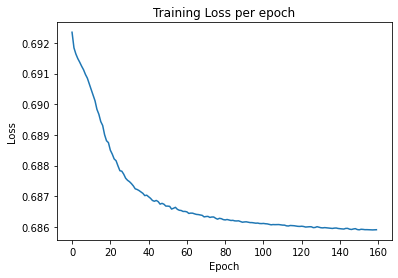

In [268]:
model_colorization = CAE4().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.RMSprop(model_colorization.parameters(), lr=0.001)


EPOCHS = 1000
def train4(model, save):
    train_loss_history = []
    for epoch in range(EPOCHS):
        train_loss = 0.0
        test_loss = 0.0
        for i in range(BATCH_SIZE):

            input = x_train[i].float().to(device)
            target = y_train[i].float().to(device)

            # Before the backward pass, set gradients to zero
            optimizer.zero_grad()

            # predict
            output = model.forward(input)  # chrominance

            # compute loss
            loss = criterion(output, target)
            train_loss += float(loss.item())

            # backpropagate loss error
            loss.backward()

            # optimize with backprop
            optimizer.step()
            del input, target

        # region print current loss
        train_loss_epoch = train_loss / BATCH_SIZE
        train_loss_history.append(train_loss_epoch)

        if epoch > 11 and train_loss_epoch > train_loss_history[-10]:
            print("Early stop")
            break

        if epoch%50 == 0:
            print("Epoch " + str(epoch) + ", Loss = " + str(train_loss_epoch))

        if epoch > 1 and train_loss_history[-1] < train_loss_history[-2]:
            # SAVE THE MODEL
            torch.save(model.state_dict(), save)



    print("Training finished")

    # PLOT ACCURACY
    plt.plot(train_loss_history)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Training Loss per epoch')
    plt.show()

train4(model_colorization, SAVE_PATH4)

### Test reconstruction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Latent space shape: torch.Size([64, 32, 8, 8])


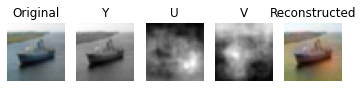

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


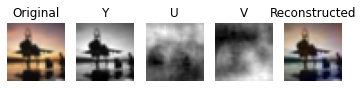

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


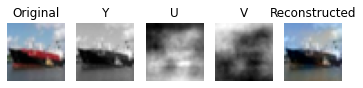

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


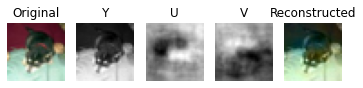

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


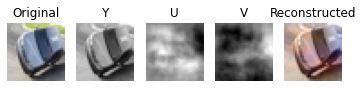

In [269]:
cae4 = CAE4()
cae4.load_state_dict(torch.load(SAVE_PATH4))
cae4.eval()

for i in range(5):
    idx1 = np.random.randint(0, 157)
    lumi = x_test[idx1].float()
    chrom = cae4.forward(lumi)
    plot_colorization(lumi[0], chrom[0].detach(), idx1)

### Colorization task conclusions

- The colorization performance improves when the decoder is defined by linear layers instead of
convolutional layers.
- Without ReLu performance decreases.
- Best Kernel size so far is 3 x 3.
- Stride of 2 x 2 at convolutional layers works worse than using 2 x 2 pooling layers after convolution.
This makes the model train for more epochs before overfitting happens.
- Using padding at each convolution layer works better than only one padding layer.
- The best optimizer is RSMprop. Adam and SGD perform much worse.
- Optimal learning rate for colorization much smaller than for reconstruction, since the cost function
is more complex. By making smaller steps a deeper minimum is found.
- Dropout layers decrease performance.
- It is clear that the model needs improvement.